In [17]:
# Plots for section 4.3 (mv and technology operation)

In [18]:
# TODO

## Imports

In [19]:
import pandas as pd
import geopandas as gpd
import numpy as np
import pypsa
import math
import seaborn as sns
import cartopy
import cartopy.crs as ccrs
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
from shapely.geometry import Point, LineString
import matplotlib.patheffects as pe
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from datetime import date, datetime, time, timedelta

# imported own functions
from utils import market_values, market_values_by_time_index, nodal_balance, capacity, capacity_links, \
    capacity_storage_units, get_condense_sum, nodal_balance, generation, generation_links, \
    generation_storage_units, market_values_storage_units, market_values_links, time_stored_LIFO

# imported own definitions
from utils import carrier_colors, carrier_renaming, carrier_renaming_reverse, resistive_heater, gas_boiler, heat_pump,\
    water_tanks_charger, water_tanks_discharger, solar_thermal

# general variables
font1 = {'fontname': 'Calibri'}
PLOT_DIR = 'C:/Users/Julian/Studies/Master/01 TU Berlin/3. Semester - Masterarbeit/MA Marktwerte FEE/data/plots/01_general/4.3_systems_mv'
onshore_regions = gpd.read_file("../data/external/regions_onshore_elec_s_181.geojson")
offshore_regions = gpd.read_file("../data/external/regions_offshore_elec_s_181.geojson")
onshore_regions = onshore_regions.set_index('name')
offshore_regions = offshore_regions.set_index('name')

# Network imports
stst = pypsa.Network("../data/raw/elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc")
exp = pypsa.Network("../data/raw/elec_s_181_lvopt__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10_2030.nc")

# Notebook Definitions
c1_groups = [resistive_heater, gas_boiler, heat_pump, water_tanks_charger, water_tanks_discharger, solar_thermal]
c1_groups_name = ["resistive heater", "gas boiler", "heat pump", "water tanks charger", "water tanks discharger",
                  "solar thermal"]
markers = ["v", "^", "<", ">", "1", "2", "3", "4", "*", "+", "d", "o", "|", "s", "P", "p", "h"]

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version [0, 18, 1].

INFO:pypsa.io:Imported network elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version [0, 18, 1].

INFO:pypsa.io:Imported network elec_s_181_lvopt__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [20]:
# Notebook Functions


In [21]:
# Regions
onshore_regions['coords'] = onshore_regions['geometry'].apply(lambda x: x.representative_point().coords[:])
onshore_regions['coords'] = [coords[0] for coords in onshore_regions['coords']]
onshore_regions["name"] = onshore_regions.index
offshore_regions['coords'] = offshore_regions['geometry'].apply(lambda x: x.representative_point().coords[:])
offshore_regions['coords'] = [coords[0] for coords in offshore_regions['coords']]
offshore_regions["name"] = offshore_regions.index

## CALC

In [105]:
# calc market values, generation, lmps, capacity factors for generators, links and storage units
for n in [stst, exp]:
    df_regions_onshore = onshore_regions.copy()
    df_regions_offshore = offshore_regions.copy()

    # function for carriers in n.generators.carrier.unique() #13
    for carrier in n.generators.carrier.unique():
        df_regions_onshore[f"{carrier}_mv"] = market_values(n, carrier)
        df_regions_offshore[f"{carrier}_mv"] = market_values(n, carrier)
        # ???????generation in TWh (does this have to be multiplied by 3???????
        df_regions_onshore[f"{carrier}_gen"] = generation(n, carrier) / 1000 * 3
        df_regions_offshore[f"{carrier}_gen"] = generation(n, carrier) / 1000 * 3
        # lmps
        # capacity factors This calculation is correct? as capacity is multiplied by 2920 is the same as multiplying the generation by 3 and then dividing it by the capacity times 8760 (as cap is in MWh?)
        df_regions_onshore[f"{carrier}_cf"] = generation(n, carrier) / (capacity(n, carrier) * 2920)
        df_regions_offshore[f"{carrier}_cf"] = generation(n, carrier) / (capacity(n, carrier) * 2920)

    # function for carriers in n.links.carrier.unique() #53
    for carrier in n.links.carrier.unique():
        df_regions_onshore[f"{carrier}_mv"] = market_values_links(n, carrier)
        df_regions_onshore[f"{carrier}_gen"] = generation_links(n, carrier) / 1000 * 3
        df_regions_onshore[f"{carrier}_cf"] = generation_links(n, carrier) / (capacity_links(n, carrier) * 2920)

    # function for carriers in n.storage_units.carrier.unique() #2
    for carrier in n.storage_units.carrier.unique():
        df_regions_onshore[f"{carrier}_mv"] = market_values_storage_units(n, carrier)
        df_regions_onshore[f"{carrier}_gen"] = generation_storage_units(n, carrier) / 1000 * 3
        # capacity factors (both generation and consumption(loading) is considered
        gen = abs(n.storage_units_t.p.loc[:, n.storage_units.carrier == carrier])
        gen.columns = gen.columns.map(n.storage_units.bus)
        gen.columns = gen.columns.map(n.buses.location)
        df_regions_onshore[f"{carrier}_cf"] = gen.sum() / (capacity_storage_units(n, carrier) * 2920)

    # set market values to nan where generation in corresponding region is lower than % quantile
    qt = 0.2
    for carrier in (n.generators.carrier.unique().tolist() +
                    n.links.carrier.unique().tolist() +
                    n.storage_units.carrier.unique().tolist()):
        index = df_regions_onshore[f"{carrier}_gen"] <= np.nanquantile(df_regions_onshore[f"{carrier}_gen"], qt)
        df_regions_onshore[f"{carrier}_mv"][index] = np.nan

    # calc lmps at the buses (lmps that are only present for EU (e.g. oil) are nan at the moment)
    # TODO: decide if EU lmps are used as lmp for all regions
    for carrier_bus in n.buses.carrier.unique():
        # index would be same names as the bus (not the location as it is in the index of
        # df_regions_onshore so far -> map location to make sure the right lmp is set
        locs = n.buses.location[n.buses[n.buses.carrier == carrier_bus].index]
        lmps = n.buses_t.marginal_price[n.buses[n.buses.carrier == carrier_bus].index].mean()
        df = pd.concat([lmps, locs], axis=1).rename(columns={0: f"{carrier_bus}_lmp"})
        df.set_index("location", inplace=True)
        if df.size == 1:
            if df.index == "EU":
                df = pd.DataFrame(np.repeat(df.values, 181), index=df_regions_onshore.index,
                                  columns=[f"{carrier_bus}_lmp"])
                df_regions_onshore[f"{carrier_bus}_lmp"] = df[f"{carrier_bus}_lmp"]
        else:
            df_regions_onshore[f"{carrier_bus}_lmp"] = df[f"{carrier_bus}_lmp"]

    if n == stst:
        df_stst_ons = df_regions_onshore
        df_stst_off = df_regions_offshore

    if n == exp:
        df_exp_ons = df_regions_onshore
        df_exp_off = df_regions_offshore

df_stst_ons.head()

,geometry,coords,name,offwind-ac_mv,offwind-ac_gen,offwind-ac_cf,onwind_mv,onwind_gen,onwind_cf,solar_mv,...,urban central water tanks_lmp,biogas_lmp,solid biomass_lmp,solid biomass for industry_lmp,gas for industry_lmp,H2 liquid_lmp,oil_lmp,process emissions_lmp,low voltage_lmp,home battery_lmp
name,,,,,,,,,,,,,,,,,,,,,
AL0 0,"POLYGON ((20.32207 39.91318, 20.39703 39.81809...","(20.00648437943388, 41.14563914300007)",AL0 0,NaN,0.029238,0.090705,NaN,0.015125,0.038018,44.628736,...,43.532557,113.716896,102.453861,78.924392,113.135704,137.617875,50.009981,-408.520212,100.338046,100.380697
AT0 0,"POLYGON ((16.45660 47.41184, 16.43396 47.39685...","(15.700718667666258, 47.896990619088925)",AT0 0,NaN,NaN,NaN,83.457109,30395.904252,0.149667,54.679083,...,55.231280,113.716896,102.453861,78.924392,113.135704,151.448316,50.009981,-408.520212,115.006246,115.044440
AT0 1,"POLYGON ((10.08288 47.35907, 10.20928 47.37248...","(10.379200993764837, 47.18231496200006)",AT0 1,NaN,NaN,NaN,NaN,0.000348,0.004685,65.745903,...,55.553668,113.716896,102.453861,78.924392,113.135704,154.026970,50.009981,-408.520212,121.910720,121.947576
AT0 2,"POLYGON ((13.47802 46.56357, 13.23111 46.55217...","(13.805469952867842, 47.57283376100011)",AT0 2,NaN,NaN,NaN,NaN,0.014320,0.039178,58.223787,...,58.936874,113.716896,102.453861,78.924392,113.135704,148.663198,50.009981,-408.520212,112.352878,112.386673
BA0 0,"POLYGON ((17.82716 42.85312, 17.81176 42.90986...","(17.97055162265331, 43.88773569750005)",BA0 0,NaN,NaN,NaN,NaN,0.014059,0.031802,51.160537,...,51.074197,113.716896,102.453861,78.924392,113.135704,147.689672,50.009981,-408.520212,112.040690,112.006725


In [23]:
assert 0

AssertionError: 

## General

In [ ]:
# investigate in carriers with most generation for both networks
# without grid ("electricity distribution grid", "DC", "H2 pipeline", "H2 pipeline retrofitted")
# storage technologies:

carriers_el_gen = [
    "electricity distribution grid",
    "onwind",
    "solar",
    "BEV charger",
    "offwind-dc",
    "ror",
    "hydro",
    "solar rooftop",
    "offwind-ac",
    "battery charger",
    "battery discharger",
    "urban central solid biomass CHP CC",
    "V2G",
    "PHS",
    "urban central gas CHP",
    "urban central solid biomass CHP",
    "OCGT",
    "home battery charger",
    "home battery discharger",
    "H2 Fuel Cell",
    "urban central gas CHP CC",
    "DC"
]

carriers_el_con = [
    "PHS",
    "electricity distribution grid",
    "H2 Electrolysis",
    "BEV charger",
    "urban central air heat pump",
    "residential urban decentral air heat pump",
    "residential rural ground heat pump",
    "services rural ground heat pump",
    "services urban decentral air heat pump",
    "urban central resistive heater",
    "battery charger",
    "battery discharger",
    "V2G",
    "residential urban decentral resistive heater",
    "residential rural resistive heater",
    "services urban decentral resistive heater",
    "services rural resistive heater",
    "home battery charger",
    "home battery discharger",
    "DC",
    "DAC",
]

carriers_h2_gen = [
    "H2 Electrolysis",
    "SMR CC",
    "SMR"
]

carriers_h2_con = [
    "H2 liquefaction",
    "H2 Fuel Cell",
    "Sabatier",
    "Fischer-Tropsch"
]

carriers_heat_gen1 = [
    "urban central air heat pump",
    "residential urban decentral air heat pump",
    "residential rural ground heat pump",
    "services rural ground heat pump",
    "services urban decentral air heat pump",
    "urban central gas boiler",
    "urban central resistive heater",
    "residential urban decentral gas boiler",
    "urban central water tanks charger",
    "urban central water tanks discharger",
    "residential urban decentral resistive heater",
    "services urban decentral gas boiler",
    "urban central solar thermal",
    "residential rural resistive heater",
    "services urban decentral resistive heater",
    "residential rural gas boiler",
    "services rural resistive heater",
    "services rural gas boiler",
    "services rural water tanks charger",
    "residential rural water tanks charger",
    "services rural water tanks discharger",
    "residential rural water tanks discharger",
    "services urban decentral water tanks charger",
    "residential urban decentral water tanks charger",
    "services urban decentral water tanks discharger",
    "residential urban decentral water tanks discharger",
    "residential urban decentral solar thermal",
    "services urban decentral solar thermal",
    "residential rural solar thermal",
    "services rural solar thermal"
]

carriers_heat_gen2 = [
    "urban central solid biomass CHP CC",
    "urban central gas CHP",
    "urban central solid biomass CHP",
    "H2 Fuel Cell",
    "urban central gas CHP CC",
    "DAC"
]

carriers_heat_con = [
"urban central water tanks charger",
"urban central water tanks discharger",
"services rural water tanks charger",
"residential rural water tanks charger",
"services rural water tanks discharger",
"residential rural water tanks discharger",
"services urban decentral water tanks charger",
"residential urban decentral water tanks charger",
"services urban decentral water tanks discharger",
"residential urban decentral water tanks discharger",
]

# for gas, biomass, oil, process emission, C02 refer to excel table

In [ ]:
n.links[n.links.carrier == "DAC"]

In [ ]:
all_c = n.generators.carrier.unique().tolist() + n.links.carrier.unique().tolist() + n.storage_units.carrier.unique().tolist()

# carriers not in any list:
set(all_c).difference(carriers_el_gen + carriers_el_con + carriers_h2_gen + carriers_h2_con + carriers_heat_gen1 + carriers_heat_con)

In [ ]:
# Check second and third output of links
# what is with DAC?

In [106]:
# select carriers which make most sense

# ordered according to (df_stst_ons[[c + "_gen" for c in c_el_gen_s]].sum() + df_exp_ons[[c + "_gen" for c in c_el_gen_s]].sum()).sort_values(ascending=False)
# overall less than 10 MWh: urban central gas CHP CC
# Fuell cell gen: STST: 472 MWh, EXP: 2.3
# Home battery discharger: STST: 58.2 / EXP: 37.9
# OCGT: 1011; STST: EXP: 986
# "urban central solid biomass CHP": STST: 2.1 / EXP: 9034
# "urban central gas CHP" STST:  46489    EXP: 15801

c_el_gen_s = [
    "onwind",
    "solar",
    "offwind-dc",
    "hydro",
    "solar rooftop",
    "battery discharger",
    "offwind-ac",
    "ror",
    "urban central gas CHP",
    "urban central solid biomass CHP CC",
    "V2G",
    "PHS"
]

# use urban central air heat pump as only heat pump (max generation)
# use urban central resistive heater (max generation)
# overall less than 10 MWh: home battery charger
# ordered according to (df_stst_ons[[c + "_con_el" for c in c_el_con_s]].sum() + df_exp_ons[[c + "_con_el" for c in c_el_con_s]].sum()).sort_values(ascending=False)
c_el_con_s = [
    "H2 Electrolysis",
    "BEV charger",
    "battery charger",
    "urban central air heat pump",
    "urban central resistive heater",
    "PHS",
    "home battery charger"
]

carriers_h2_gen = [
    "H2 Electrolysis",
    "SMR CC",
    "SMR"
]

carriers_h2_con = [
    "H2 liquefaction",
    "H2 Fuel Cell"
    "Sabatier",
    "Fischer-Tropsch"
]

# use urban central air heat pump as only heat pump (max generation)
# use urban central resistive heater (max generation)
# use urban central gas boiler (max generation)
# use urban central water tanks charger (max generation)
# use urban central solar thermal (max generation)

carriers_heat_gen1 = [
    "urban central air heat pump"
    "urban central gas boiler"
    "urban central resistive heater"
    "urban central water tanks discharger"
    "urban central solar thermal"
]

carriers_heat_gen2 = [
    "urban central solid biomass CHP CC",
    "urban central gas CHP",
    "urban central solid biomass CHP",
    "H2 Fuel Cell",
    "urban central gas CHP CC",
    "DAC"
]

carriers_heat_con = [
"urban central water tanks charger",
]

# for gas, biomass, oil, process emission, C02 refer to excel table

#### MV across regions

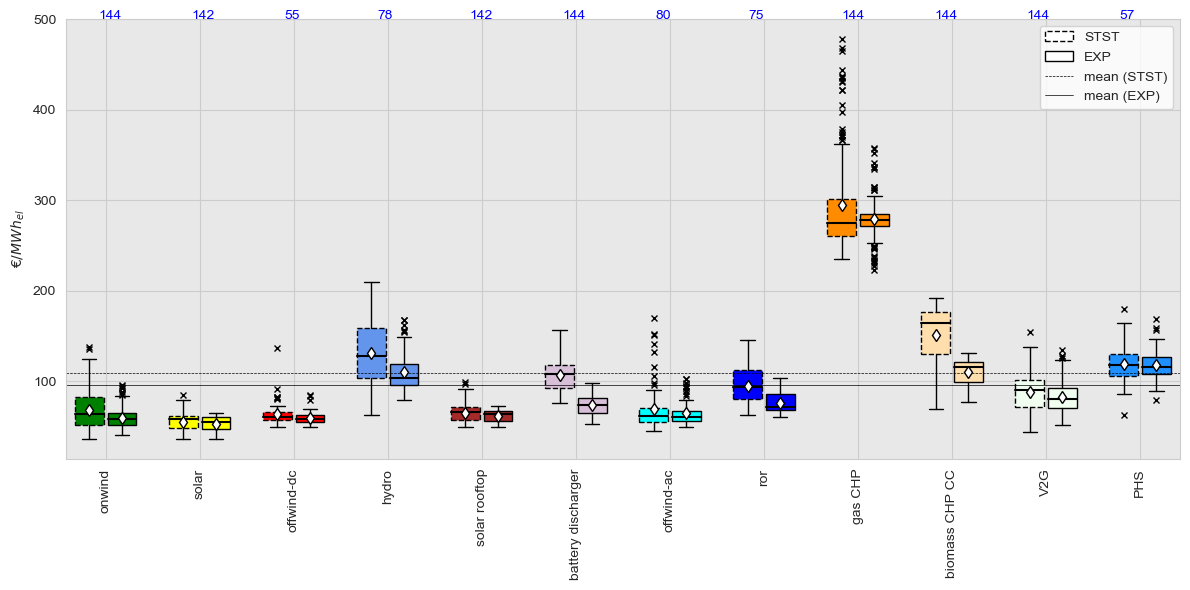

In [107]:
# electricity generating technologies

# boxplot propertes
medianprops = dict(color="black",linewidth=1.5)
meanprops = {"marker":"d","markerfacecolor":"white", "markeredgecolor":"black"}
flierprops= {'marker': 'x', 'markersize': 5, 'markeredgecolor': 'black'}
whiskerprops = dict(linestyle='-',linewidth=1.0, color='black')

# data
stst_el_gen = df_stst_ons[[c + "_mv" for c in c_el_gen_s]]
stst_el_gen = stst_el_gen.values
exp_el_gen = df_exp_ons[[c + "_mv" for c in c_el_gen_s]]
exp_el_gen = exp_el_gen.values

# Filter data using np.isnan
mask_stst = ~np.isnan(stst_el_gen)
filtered_stst = [d[m] for d, m in zip(stst_el_gen.T, mask_stst.T)]
mask_exp = ~np.isnan(exp_el_gen)
filtered_exp = [d[m] for d, m in zip(exp_el_gen.T, mask_exp.T)]

ticks = [carrier_renaming.get(n, n) for n in c_el_gen_s]
index = c_el_gen_s
fig, ax = plt.subplots(figsize=(12, 6))

stst_plot = plt.boxplot(filtered_stst,
                        positions=np.array(np.arange(len(ticks)))*2.0-0.35,
                        widths=0.6,
                        patch_artist=True,
                        showmeans=True,
                        meanprops=meanprops,
                        medianprops=medianprops,
                        flierprops=flierprops,
                        whiskerprops=whiskerprops
                        )

exp_plot = plt.boxplot(filtered_exp,
                       positions=np.array(np.arange(len(ticks)))*2.0+0.35,
                       widths=0.6,
                       patch_artist=True,
                       showmeans=True,
                       meanprops=meanprops,
                       medianprops=medianprops,
                       flierprops=flierprops,
                       whiskerprops=whiskerprops
                       )


for box, col in zip(stst_plot['boxes'],[carrier_colors[c] for c in index]):
    # change outline color
    box.set_facecolor(col)
    box.set_linestyle('--')

for box, col in zip(exp_plot['boxes'],[carrier_colors[c] for c in index]):
    # change outline color
    box.set_facecolor(col)

# sample sizes
for i, sample_size in enumerate(df_stst_ons[[f"{i}_mv" for i in index]].count()):
    ax.annotate(sample_size, xy=(0,0),  xycoords='axes fraction',
        xytext=((i+0.35)/len(index),1), textcoords='axes fraction', color="blue")

#for i, sample_size in enumerate(df_exp_ons[[f"{i}_mv" for i in index]].count()):
#    ax.annotate(sample_size, xy=(0,0),  xycoords='axes fraction',
#        xytext=((i+0.55)/len(index),1), textcoords='axes fraction', color="red")

# explanations
plt.xticks(np.arange(0, len(ticks) * 2, 2), ticks)
plt.ylabel("$€/MWh_{el}$")
plt.xticks(rotation=90)
# plt.title("Market values of electricity generating technologies across the regions (STST vs. EXP)", fontsize=16, pad=20,  **font1)

# cosmetics
ax.patch.set_facecolor('lightgrey')
ax.patch.set_alpha(0.5)

# horizontal lines
ax.axhline(df_stst_ons[[c + "_mv" for c in c_el_gen_s]].mean().mean(), ls="--", c='black',linewidth=0.5)
ax.axhline(df_exp_ons[[c + "_mv" for c in c_el_gen_s]].mean().mean(), ls="-", c='black', linewidth=0.5)

# legend
patch1 = matplotlib.patches.Patch(ls="--", facecolor="white", edgecolor="black")
patch2 = matplotlib.patches.Patch(ls="-", facecolor="white", edgecolor="black")
line1 = Line2D([0], [0], ls="--", c='black', label="mean (STST)", linewidth=0.5)
line2 = Line2D([0], [0], ls="-", c='black', label="mean (EXP)", linewidth=0.5)
ax.legend([patch1, patch2, line1, line2], ['STST', 'EXP', 'mean (STST)','mean (EXP)'])

fig.tight_layout()
plt.show()

# fig.savefig(f"{PLOT_DIR}/mv_el_gen_both_box.png")

In [ ]:
df_stst_ons[[c + "_mv" for c in c_el_gen_s]].mean().mean()

In [ ]:
df_exp_ons[[c + "_mv" for c in c_el_gen_s]].mean().mean()

In [ ]:
df_stst_ons[[c + "_mv" for c in c_el_gen_s]].mean() - df_exp_ons[[c + "_mv" for c in c_el_gen_s]].mean()

In [ ]:
(df_stst_ons[[c + "_mv" for c in c_el_gen_s]].mean() - df_exp_ons[[c + "_mv" for c in c_el_gen_s]].mean()) / df_stst_ons[[c + "_mv" for c in c_el_gen_s]].mean()

In [ ]:
(df_stst_ons[[c + "_mv" for c in c_el_gen_s]].describe().loc["75%"] - df_stst_ons[[c + "_mv" for c in c_el_gen_s]].describe().loc["25%"]) - (df_exp_ons[[c + "_mv" for c in c_el_gen_s]].describe().loc["75%"] - df_exp_ons[[c + "_mv" for c in c_el_gen_s]].describe().loc["25%"])

In [ ]:
(df_stst_ons[[c + "_mv" for c in c_el_gen_s]].describe().loc["std"] -  df_exp_ons[[c + "_mv" for c in c_el_gen_s]].describe().loc["std"])

In [ ]:
df_stst_ons[[c + "_mv" for c in c_el_gen_s]].mean().sort_values()

In [ ]:
df_exp_ons[[c + "_mv" for c in c_el_gen_s]].mean().sort_values()

In [72]:
# electricity consuming technologies
c_el_con_s

['H2 Electrolysis',
 'BEV charger',
 'urban central air heat pump',
 'battery charger',
 'urban central resistive heater',
 'PHS',
 'home battery charger']

In [117]:
# consumed electric energy and prices payed
# AC and low voltage are the main buses for electricity (why the difference?) Investigate in differences in lmps?

for n , df in zip([stst, exp], [df_stst_ons, df_exp_ons]):

    for c in c_el_con_s:

        # links
        if c in n.links.carrier.unique().tolist():
            # check if bus 0 is AC or low voltage bus
            if n.links[n.links.carrier == c].bus0.map(n.buses.carrier).unique() in ["AC", "low voltage"]:

                # consumption of link at bus 0
                con = n.links_t.p0.loc[:, n.links.carrier == c]
                con.columns = con.columns.map(n.links.bus0)
                # save consumption per location to df
                con_sum = con.sum()
                con_sum.index = con_sum.index.map(n.buses.location)
                # convert to TWh
                df[f"{c}_con_el"] = con_sum / 1000 * 3
                # get lmp of buses where the links consumes from
                lmp_con = n.buses_t.marginal_price.loc[:, con.columns]
                # calculate costs for every time step and location
                overall_cost = con * lmp_con
                # calc consumption weighted average per location: overall cost per location / overall generation per location
                cost_mv = overall_cost.sum() / con.sum()
                cost_mv.index = cost_mv.index.map(n.buses.location)
                # save cost_mv to df (€/MWH_el)
                df[f"{c}_cost_mv_el"] = cost_mv

        # storage unit: only PHS can store
        elif c in n.storage_units.carrier.unique().tolist():

                # consumption of su
                con = n.storage_units_t.p_store.loc[:, n.storage_units.carrier == c]
                con.columns = con.columns.map(n.storage_units.bus)
                # save consumption per location to df in TWh
                df[f"{c}_con_el"] = con.sum() / 1000 * 3
                # get lmp of buses where the su consumes from
                lmp_con = n.buses_t.marginal_price.loc[:, con.columns]
                # calculate costs for every time step and location
                overall_cost = con * lmp_con
                # calc consumption weighted average per location: overall cost per location / overall generation per location
                cost_mv = overall_cost.sum() / con.sum()
                # save cost_mv to df
                df[f"{c}_cost_mv_el"] = cost_mv

        else:
            print(f"{c} not found!")

        # set pries to nan where generation in corresponding region is lower than % quantile
        qt = 0.2
        index = df[f"{c}_con_el"] <= np.nanquantile(df[f"{c}_con_el"], qt)
        df[f"{c}_cost_mv_el"][index] = np.nan

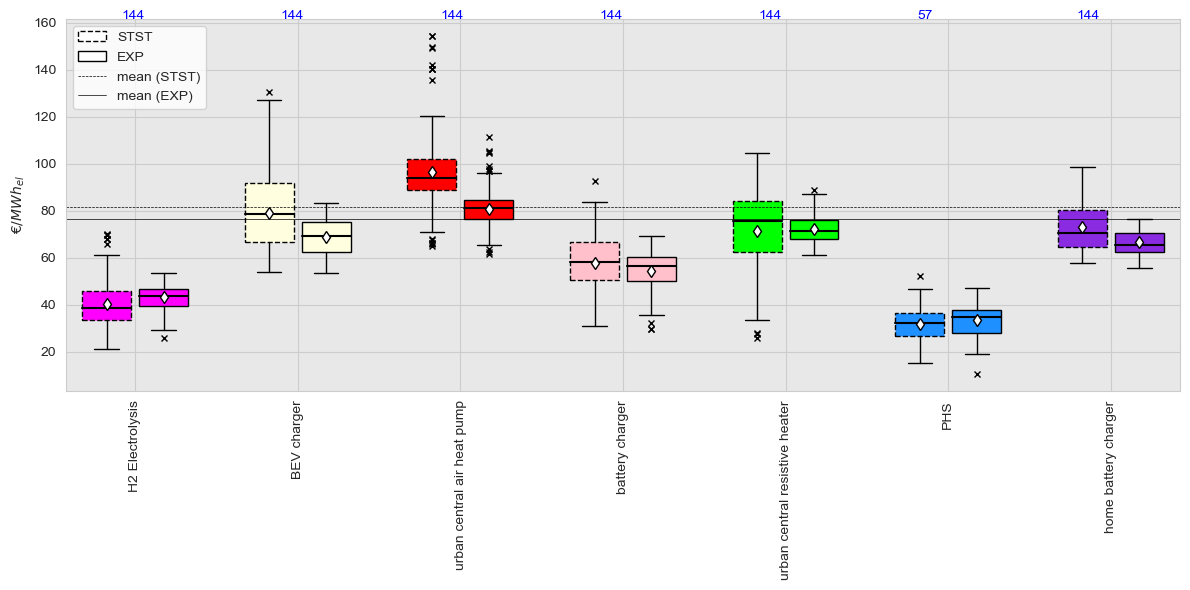

In [119]:
# electricity consuming technologies

# boxplot properties
medianprops = dict(color="black",linewidth=1.5)
meanprops = {"marker":"d","markerfacecolor":"white", "markeredgecolor":"black"}
flierprops= {'marker': 'x', 'markersize': 5, 'markeredgecolor': 'black'}
whiskerprops = dict(linestyle='-',linewidth=1.0, color='black')

# data
stst_el_con = df_stst_ons[[c + "_cost_mv_el" for c in c_el_con_s]]
stst_el_con = stst_el_con.values
exp_el_con = df_exp_ons[[c + "_cost_mv_el" for c in c_el_con_s]]
exp_el_con = exp_el_con.values

# Filter data using np.isnan
mask_stst = ~np.isnan(stst_el_con)
filtered_stst = [d[m] for d, m in zip(stst_el_con.T, mask_stst.T)]
mask_exp = ~np.isnan(exp_el_con)
filtered_exp = [d[m] for d, m in zip(exp_el_con.T, mask_exp.T)]

ticks = [carrier_renaming.get(n, n) for n in c_el_con_s]
index = c_el_con_s
fig, ax = plt.subplots(figsize=(12, 6))

stst_plot = plt.boxplot(filtered_stst,
                        positions=np.array(np.arange(len(ticks)))*2.0-0.35,
                        widths=0.6,
                        patch_artist=True,
                        showmeans=True,
                        meanprops=meanprops,
                        medianprops=medianprops,
                        flierprops=flierprops,
                        whiskerprops=whiskerprops
                        )

exp_plot = plt.boxplot(filtered_exp,
                       positions=np.array(np.arange(len(ticks)))*2.0+0.35,
                       widths=0.6,
                       patch_artist=True,
                       showmeans=True,
                       meanprops=meanprops,
                       medianprops=medianprops,
                       flierprops=flierprops,
                       whiskerprops=whiskerprops
                       )


for box, col in zip(stst_plot['boxes'],[carrier_colors[c] for c in index]):
    # change outline color
    box.set_facecolor(col)
    box.set_linestyle('--')

for box, col in zip(exp_plot['boxes'],[carrier_colors[c] for c in index]):
    # change outline color
    box.set_facecolor(col)

# sample sizes
for i, sample_size in enumerate(df_stst_ons[[f"{i}_cost_mv_el" for i in index]].count()):
    ax.annotate(sample_size, xy=(0,0),  xycoords='axes fraction',
        xytext=((i+0.35)/len(index),1), textcoords='axes fraction', color="blue")

#for i, sample_size in enumerate(df_exp_ons[[f"{i}_cost_mv_el" for i in index]].count()):
#    ax.annotate(sample_size, xy=(0,0),  xycoords='axes fraction',
#        xytext=((i+0.55)/len(index),1), textcoords='axes fraction', color="red")

# explanations
plt.xticks(np.arange(0, len(ticks) * 2, 2), ticks)
plt.ylabel("$€/MWh_{el}$")
plt.xticks(rotation=90)
# plt.title("Market values of electricity consuming technologies across the regions (STST vs. EXP)", fontsize=16, pad=20,  **font1)

# cosmetics
ax.patch.set_facecolor('lightgrey')
ax.patch.set_alpha(0.5)

# horizontal lines
ax.axhline(df_stst_ons[[c + "_mv" for c in c_el_con_s]].mean().mean(), ls="--", c='black',linewidth=0.5)
ax.axhline(df_exp_ons[[c + "_mv" for c in c_el_con_s]].mean().mean(), ls="-", c='black', linewidth=0.5)

# legend
patch1 = matplotlib.patches.Patch(ls="--", facecolor="white", edgecolor="black")
patch2 = matplotlib.patches.Patch(ls="-", facecolor="white", edgecolor="black")
line1 = Line2D([0], [0], ls="--", c='black', label="mean (STST)", linewidth=0.5)
line2 = Line2D([0], [0], ls="-", c='black', label="mean (EXP)", linewidth=0.5)
ax.legend([patch1, patch2, line1, line2], ['STST', 'EXP', 'mean (STST)','mean (EXP)'], loc="upper left")

fig.tight_layout()
plt.show()

fig.savefig(f"{PLOT_DIR}/mv_el_con_both_box.png")

In [98]:
df_stst_ons

,geometry,coords,name,offwind-ac_mv,offwind-ac_gen,offwind-ac_cf,onwind_mv,onwind_gen,onwind_cf,solar_mv,...,urban central air heat pump_con_el,urban central air heat pump_cost_mv_el,battery charger_con_el,battery charger_cost_mv_el,urban central resistive heater_con_el,urban central resistive heater_cost_mv_el,home battery charger_con_el,home battery charger_cost_mv_el,PHS_con_el,PHS_cost_mv_el
name,,,,,,,,,,,,,,,,,,,,,
AL0 0,"POLYGON ((20.32207 39.91318, 20.39703 39.81809...","(20.00648437943388, 41.14563914300007)",AL0 0,NaN,0.009746,0.090705,NaN,0.005042,0.038018,44.628736,...,5.371421e+04,142.000494,3.500402e+06,54.167322,2195.741306,51.370506,329.272821,77.741272,NaN,NaN
AT0 0,"POLYGON ((16.45660 47.41184, 16.43396 47.39685...","(15.700718667666258, 47.896990619088925)",AT0 0,NaN,NaN,NaN,83.457109,10131.968084,0.149667,54.679083,...,6.309900e+05,96.915190,3.220617e+03,66.778969,455543.340614,46.402280,311.469020,91.637564,NaN,NaN
AT0 1,"POLYGON ((10.08288 47.35907, 10.20928 47.37248...","(10.379200993764837, 47.18231496200006)",AT0 1,NaN,NaN,NaN,NaN,0.000116,0.004685,65.745903,...,1.224615e+03,90.315217,6.267143e+05,75.537145,36118.325910,54.638572,270.442960,97.878519,7.403542e+05,35.149114
AT0 2,"POLYGON ((13.47802 46.56357, 13.23111 46.55217...","(13.805469952867842, 47.57283376100011)",AT0 2,NaN,NaN,NaN,NaN,0.004773,0.039178,58.223787,...,2.227419e+05,92.091020,1.959994e+06,60.525947,259254.487066,33.551977,307.628948,89.189422,1.635746e+06,46.836646
BA0 0,"POLYGON ((17.82716 42.85312, 17.81176 42.90986...","(17.97055162265331, 43.88773569750005)",BA0 0,NaN,NaN,NaN,NaN,0.004686,0.031802,51.160537,...,5.910552e+04,96.225890,1.607878e+06,64.621258,32004.938582,38.225192,359.272135,87.173916,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SE3 5,"MULTIPOLYGON (((12.61378 61.54705, 12.41648 61...","(13.73128235630574, 63.53620046050007)",SE3 5,NaN,NaN,NaN,NaN,0.036250,0.121408,NaN,...,6.955206e+03,63.509403,4.967918e+02,58.145324,12750.015241,52.451539,379.845257,62.745367,NaN,NaN
SE3 6,"POLYGON ((12.61573 56.75007, 12.59474 56.78799...","(12.822816168194691, 59.049790757500105)",SE3 6,60.483666,0.179703,0.311612,53.277864,3278.886421,0.234480,58.963028,...,1.232436e+06,78.910682,5.167672e+02,62.914926,461723.585013,94.024615,351.801602,70.830440,1.931810e+04,30.803991
SE3 7,"MULTIPOLYGON (((22.40528 65.54194, 22.39038 65...","(21.745513796594864, 66.5111868290001)",SE3 7,59.877949,0.064995,0.262892,63.297661,0.112590,0.159627,NaN,...,4.776884e+02,63.122628,4.885445e+02,57.200532,615.804418,37.450425,384.227710,60.516535,NaN,NaN


In [83]:
df_exp_ons

,geometry,coords,name,offwind-ac_mv,offwind-ac_gen,offwind-ac_cf,onwind_mv,onwind_gen,onwind_cf,solar_mv,...,BEV charger_con_el,BEV charger_cost_mv_el,urban central air heat pump_con_el,urban central air heat pump_cost_mv_el,battery charger_con_el,battery charger_cost_mv_el,urban central resistive heater_con_el,urban central resistive heater_cost_mv_el,home battery charger_con_el,home battery charger_cost_mv_el
name,,,,,,,,,,,,,,,,,,,,,
AL0 0,"POLYGON ((20.32207 39.91318, 20.39703 39.81809...","(20.00648437943388, 41.14563914300007)",AL0 0,NaN,0.005444,0.087899,NaN,0.005474,0.043458,43.422954,...,9.104402e+05,61.820816,61022.168873,101.617344,1865.752394,48.523475,20065.103547,83.481522,208.625174,70.189710
AT0 0,"POLYGON ((16.45660 47.41184, 16.43396 47.39685...","(15.700718667666258, 47.896990619088925)",AT0 0,NaN,NaN,NaN,79.253841,0.189118,0.144707,55.129859,...,3.894517e+06,82.429501,652662.872783,75.914663,330.455337,65.752773,163396.936468,63.791026,188.371804,75.562972
AT0 1,"POLYGON ((10.08288 47.35907, 10.20928 47.37248...","(10.379200993764837, 47.18231496200006)",AT0 1,NaN,NaN,NaN,NaN,0.000109,0.004923,57.245535,...,4.891482e+05,81.263205,102.393402,74.711860,264.568711,63.957909,18759.196709,59.187063,148.312787,74.026664
AT0 2,"POLYGON ((13.47802 46.56357, 13.23111 46.55217...","(13.805469952867842, 47.57283376100011)",AT0 2,NaN,NaN,NaN,NaN,0.004312,0.044168,54.745027,...,2.404406e+06,81.186546,87901.114716,76.701790,416.117601,63.330463,81410.574598,61.638273,206.494226,74.976652
BA0 0,"POLYGON ((17.82716 42.85312, 17.81176 42.90986...","(17.97055162265331, 43.88773569750005)",BA0 0,NaN,NaN,NaN,NaN,0.003540,0.031748,51.151356,...,8.499061e+05,57.625222,54925.441559,78.079794,485.936812,62.045594,22521.207255,70.452362,220.690000,73.319331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SE3 5,"MULTIPOLYGON (((12.61378 61.54705, 12.41648 61...","(13.73128235630574, 63.53620046050007)",SE3 5,NaN,NaN,NaN,60.776803,0.056615,0.145875,NaN,...,1.614523e+05,65.756275,2939.682191,61.015921,347.793934,58.723813,10294.402967,56.156304,272.080762,62.621098
SE3 6,"POLYGON ((12.61573 56.75007, 12.59474 56.78799...","(12.822816168194691, 59.049790757500105)",SE3 6,54.674059,0.051862,0.280442,53.126362,0.131500,0.195409,58.896406,...,1.340622e+06,69.150354,696470.439136,70.551099,350.256371,58.800693,599777.435615,81.893585,261.449427,65.107868
SE3 7,"MULTIPOLYGON (((22.40528 65.54194, 22.39038 65...","(21.745513796594864, 66.5111868290001)",SE3 7,64.502215,0.056895,0.264344,63.069417,0.100063,0.162114,NaN,...,1.063981e+05,61.420432,841.109457,59.728437,353.693099,57.548379,579.818297,44.150305,278.046640,60.995699


In [111]:
(df_stst_ons[[c + "_con_el" for c in c_el_con_s]].sum() + df_exp_ons[[c + "_con_el" for c in c_el_con_s]].sum()).sort_values(ascending=False)

H2 Electrolysis_con_el                   7.800233e+06
BEV charger_con_el                       1.936009e+06
battery charger_con_el                   5.173024e+05
urban central air heat pump_con_el       4.981119e+05
urban central resistive heater_con_el    2.561987e+05
PHS_con_el                               1.490256e+05
home battery charger_con_el              3.003420e+02
dtype: float64

In [101]:
df_stst_ons[[c + "_con_el" for c in c_el_con_s]].sum()

H2 Electrolysis_con_el                   1.414038e+06
BEV charger_con_el                       3.299058e+05
urban central air heat pump_con_el       8.559993e+04
battery charger_con_el                   1.347316e+05
urban central resistive heater_con_el    4.333076e+04
PHS_con_el                               2.609673e+04
home battery charger_con_el              6.062268e+01
dtype: float64

In [109]:
df_stst_ons["home battery charger_con_el"].sum()

181.86802721438812

In [110]:
df_stst_ons["home battery discharger_gen"].sum()

174.59332261552856

In [50]:

transform_columns = n.links_t.p0.loc[:, n.links.carrier == c].columns.map(n.links.bus1)
con.columns = con.columns.map(n.links.bus0)
lmp_con = n.buses_t.marginal_price.loc[:, con.columns]
cost = con * lmp_con

In [52]:
con

Link,AL0 0 low voltage,AT0 0 low voltage,AT0 1 low voltage,AT0 2 low voltage,BA0 0 low voltage,BE0 0 low voltage,BE0 1 low voltage,BE0 2 low voltage,BE0 3 low voltage,BE0 4 low voltage,...,SE3 0 low voltage,SE3 1 low voltage,SE3 2 low voltage,SE3 3 low voltage,SE3 4 low voltage,SE3 5 low voltage,SE3 6 low voltage,SE3 7 low voltage,SI0 0 low voltage,SK0 0 low voltage
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,0.058514,0.048196,0.118917,0.096217,0.063928,0.117550,0.117903,0.076787,0.090191,0.079491,...,0.163195,0.167000,0.164453,0.169312,0.163925,0.154062,0.115765,0.175172,0.061081,0.110261
2013-01-01 03:00:00,0.049143,0.049113,0.104469,0.088134,0.053271,0.117696,0.075314,0.078107,0.089347,0.082477,...,0.146278,0.147160,0.146877,0.155515,0.145228,0.153801,0.125058,0.154216,0.057664,0.107040
2013-01-01 06:00:00,0.101031,0.116081,0.102157,0.086901,0.130644,0.122177,0.089752,0.081185,0.093037,0.079844,...,0.146900,0.147802,0.143794,0.165248,0.145542,0.148906,0.125068,0.154720,0.052444,0.103297
2013-01-01 09:00:00,0.142588,0.113595,0.105153,0.097846,0.171901,0.134505,0.122543,0.091981,0.108251,0.091167,...,0.157348,0.160952,0.160537,0.145312,0.161419,0.172571,0.129896,0.167557,0.151000,0.112279
2013-01-01 12:00:00,0.149692,0.134640,0.136377,0.123876,0.181890,0.158762,0.136894,0.116640,0.107424,0.119122,...,0.111752,0.112167,0.111692,0.106720,0.108148,0.101965,0.129710,0.108007,0.141927,0.107655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 09:00:00,0.095874,0.124051,0.142851,0.139310,0.110101,0.121565,0.135831,0.114609,0.128907,0.122142,...,0.169682,0.169562,0.174156,0.170745,0.142414,0.190029,0.156317,0.160342,0.070129,0.176328
2013-12-31 12:00:00,0.106879,0.092444,0.131772,0.127085,0.165679,0.121939,0.112536,0.085446,0.098952,0.100936,...,0.131343,0.136621,0.132216,0.131019,0.145598,0.125347,0.134982,0.146257,0.067393,0.155805
2013-12-31 15:00:00,0.053186,0.086768,0.080252,0.059403,0.039084,0.120918,0.109564,0.082919,0.096601,0.052810,...,0.141898,0.146867,0.143751,0.144040,0.144409,0.146076,0.141893,0.149943,0.072633,0.073276


In [46]:
c_el_con_s

['H2 Electrolysis',
 'BEV charger',
 'urban central air heat pump',
 'battery charger',
 'urban central resistive heater',
 'PHS',
 'home battery charger']

In [35]:
n.buses.carrier

,v_nom,x,y,country,control,generator,carrier,location,type,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,sub_network
Bus,,,,,,,,,,,,,,
AL0 0,380.0,19.894573,41.561804,AL,Slack,AL0 0 offwind-ac,AC,AL0 0,,None,1.0,0.0,inf,
AT0 0,380.0,15.759790,47.898676,AT,PQ,,AC,AT0 0,,None,1.0,0.0,inf,
AT0 1,380.0,10.293250,47.248827,AT,PQ,,AC,AT0 1,,None,1.0,0.0,inf,
AT0 2,380.0,13.580650,47.413095,AT,PQ,,AC,AT0 2,,None,1.0,0.0,inf,
BA0 0,380.0,18.122704,43.811367,BA,PQ,,AC,BA0 0,,None,1.0,0.0,inf,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SE3 5 home battery,1.0,0.000000,0.000000,,Slack,,home battery,SE3 5,,None,1.0,0.0,inf,
SE3 6 home battery,1.0,0.000000,0.000000,,Slack,,home battery,SE3 6,,None,1.0,0.0,inf,
SE3 7 home battery,1.0,0.000000,0.000000,,Slack,,home battery,SE3 7,,None,1.0,0.0,inf,
